# Churn

## 1 - Import useful modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

## 2 - Load and prepare dataset

In [2]:
X_train = pd.read_csv('data/bank_data_train.csv', index_col='ID')

Y_train = X_train.pop('TARGET')

In [3]:
# Drop columns that only have one unique value
useless_cols = [col for col in X_train.columns if len(pd.Series(X_train[col].unique()).dropna()) <= 1]
useless_cols = useless_cols
X_train.drop(columns=useless_cols, inplace=True)

Lower case categorical columns to avoid duplicates.

In [4]:
X_train_categorical = X_train.select_dtypes(include=["object_"])
categorical_cols = X_train_categorical.columns
X_train.drop(columns=categorical_cols, inplace=True)
X_train_categorical = X_train_categorical.apply(lambda c: c.str.lower())

Deal with duplicates in the `CLNT_TRUST_RELATION` column by translating Russian terms to their equivalent in English.

In [5]:
ru_to_en = {'друг': 'other', 'мать': 'mother', 'брат': 'brother', 'отец': 'father', 'сестра': 'sister', 'дочь': 'daughter', 'сын': 'son', 'мама': 'mother'}
X_train_categorical['CLNT_TRUST_RELATION'].replace(ru_to_en, inplace=True)
X_train_categorical.describe()

,CLNT_TRUST_RELATION,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,APP_COMP_TYPE,PACK
count,69421,68234,59361,44781,210811,57257,68104,57257,57256,60545,67362,67362,355190
unique,13,8,5,4,15111,2,12,2,2,4,4,4,12
top,friend,m,so,specialist,директор,n,h,n,n,specialist,private,private,102
freq,24896,32185,28056,25123,24974,36332,44370,52750,32843,36622,59087,59087,116986


Split the training set into a train dataset (80%) and a dev set (20%) with stratification.

In [6]:
Y_train.value_counts() / len(Y_train)

0    0.918565
1    0.081435
Name: TARGET, dtype: float64

In [7]:
X_train, X_dev, X_train_categorical, X_dev_categorical, Y_train, Y_dev = train_test_split(X_train, X_train_categorical, Y_train, test_size=0.2, stratify=Y_train, random_state=1337)

Fill NA values.

In [8]:
medians = X_train.median(numeric_only=True)
X_train.fillna(medians, inplace=True)
X_dev.fillna(medians, inplace=True)

## 3 - Baseline - naive classifier

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
class Baseline:
    def __init__(self):
        self.prediction = 0

    def fit(self, X, y):
        classes = set(y)
        frequencies = {cls: (Y_train == cls).sum() for cls in classes}
        self.prediction = max(frequencies, key=frequencies.get)

    def predict(self, X):
        return np.full(X.shape[0], self.prediction)

In [11]:
bsl = Baseline()
bsl.fit(X_train, Y_train)
dev_predictions = bsl.predict(X_dev)

In [12]:
roc_auc_score(Y_dev, dev_predictions)

0.5

## 4 - Baseline - random forest

Label-encode categorical features.

In [13]:
cjp_categories = X_train_categorical['CLNT_JOB_POSITION'].value_counts().iloc[:15].index

In [14]:
X_train_categorical_encoded = X_train_categorical.astype(pd.CategoricalDtype())
X_dev_categorical_encoded = pd.DataFrame()

In [15]:
X_train_categorical_encoded['CLNT_JOB_POSITION'] = X_train_categorical['CLNT_JOB_POSITION'].astype(pd.CategoricalDtype(cjp_categories))

In [16]:
categories = {}
for col in categorical_cols:
    cat = X_train_categorical_encoded[col].cat.categories
    categories[col] = cat
    X_dev_categorical_encoded[col] = X_dev_categorical[col].astype(pd.CategoricalDtype(categories=cat))
    X_train_categorical_encoded[col] = X_train_categorical_encoded[col].cat.codes
    X_dev_categorical_encoded[col] = X_dev_categorical_encoded[col].cat.codes

In [17]:
del(X_train_categorical)
del(X_dev_categorical)

In [18]:
X_train = pd.concat([X_train, X_train_categorical_encoded], axis=1)
X_dev = pd.concat([X_dev, X_dev_categorical_encoded], axis=1)

In [19]:
del(X_train_categorical_encoded)
del(X_dev_categorical_encoded)

Standardize numerical columns.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
'''parameter_grid = {'n_estimators': [32, 64, 128],
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [8, 16, 32]}

rfc = RandomForestClassifier(random_state=1337, n_jobs=-1)
grid_search = GridSearchCV(estimator=rfc, param_grid=parameter_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)
best_rfc = grid_search.best_estimator_'''

"parameter_grid = {'n_estimators': [32, 64, 128],\n                  'max_features': ['sqrt', 'log2'],\n                  'max_depth': [8, 16, 32]}\n\nrfc = RandomForestClassifier(random_state=1337, n_jobs=-1)\ngrid_search = GridSearchCV(estimator=rfc, param_grid=parameter_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)\ngrid_search.fit(X_train, Y_train)\nprint(grid_search.best_params_)\nbest_rfc = grid_search.best_estimator_"

In [23]:
best_rfc = RandomForestClassifier(random_state=1337, max_depth=16, max_features='sqrt', n_estimators=128, n_jobs=-1)
best_rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=16, n_estimators=128, n_jobs=-1,
                       random_state=1337)

In [24]:
dev_predictions = best_rfc.predict_proba(X_dev)
dev_predictions = dev_predictions[:, 1]

In [25]:
roc_auc_score(Y_dev, dev_predictions)

0.8323238061715796

In [26]:
train_predictions = best_rfc.predict_proba(X_train)
train_predictions = train_predictions[:, 1]

In [27]:
roc_auc_score(Y_train, train_predictions)

0.9437482220489808

## 5 - MLPClassifier

In [28]:
from sklearn.neural_network import MLPClassifier

In [29]:
mlp = MLPClassifier(random_state=1337, verbose=True, hidden_layer_sizes=(50,), max_iter=15)
mlp.fit(X_train, Y_train)

Iteration 1, loss = 0.28523228
Iteration 2, loss = 0.25016409
Iteration 3, loss = 0.24526579
Iteration 4, loss = 0.24166717
Iteration 5, loss = 0.23902816
Iteration 6, loss = 0.23692680
Iteration 7, loss = 0.23458404
Iteration 8, loss = 0.23331242
Iteration 9, loss = 0.23204344
Iteration 10, loss = 0.23110212
Iteration 11, loss = 0.23011958
Iteration 12, loss = 0.22950392
Iteration 13, loss = 0.22876191
Iteration 14, loss = 0.22804118
Iteration 15, loss = 0.22765978


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50,), max_iter=15, random_state=1337,
              verbose=True)

In [30]:
dev_predictions = mlp.predict_proba(X_dev)
dev_predictions = dev_predictions[:, 1]

In [31]:
roc_auc_score(Y_dev, dev_predictions)

0.8036313957079578

In [32]:
train_predictions = mlp.predict_proba(X_train)
train_predictions = train_predictions[:, 1]

In [33]:
roc_auc_score(Y_train, train_predictions)

0.825843776877053

## 6 - Keras

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import keras_tuner
import matplotlib.pyplot as plt
print("Tensorflow version " + tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Tensorflow version 2.12.0


Use accelerators if possible.

In [35]:
# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    print("No TPUs detected.")
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

No TPUs detected.
Number of accelerators:  1


In [36]:
input_shape = [X_train.shape[1]]

def build_model(hp):
    with strategy.scope():
        model = keras.Sequential()
        model.add(
            layers.Dense(
                hp.Int("units_1", min_value=50, max_value=1000, step=100), activation='relu', input_shape=input_shape
            )
        )
        for i in range(2, hp.Int("num_hidden_layers", 3, 6) + 1):
            model.add(
                layers.Dropout(
                    hp.Float(f"dropout_rate_{i}", min_value=0, max_value=0.8, step=0.2)
                )
            )
            model.add(
                layers.Dense(
                    hp.Int(f"units_{i}", min_value=50, max_value=1000, step=100),
                    activation='relu'
                )
            )
        model.add(
            layers.Dense(
                1,
                activation='sigmoid'
            )
        )

        learning_rate = hp.Float("lr", min_value=4e-4, max_value=1e-2, sampling="log")
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['AUC']
        )
    return model

In [37]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_auc", direction="max"),
    max_trials=25,
    executions_per_trial=1,
    overwrite=True,
    directory="/kaggle/working/",
    project_name="hyperparameter_tuning",
)
tuner.search_space_summary()

Search space summary
Default search space size: 7
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
num_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
dropout_rate_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
lr (Float)
{'default': 0.0004, 'conditions': [], 'min_value': 0.0004, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [38]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, min_delta=0.001, restore_best_weights=True)
tuner.search(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=100, batch_size=512, callbacks=[early_stopping])

Trial 25 Complete [00h 01m 40s]
val_auc: 0.786931037902832

Best val_auc So Far: 0.8214068412780762
Total elapsed time: 00h 40m 42s


In [39]:
tuner.results_summary()

Results summary
Results in /kaggle/working/hyperparameter_tuning
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 00 summary
Hyperparameters:
units_1: 850
num_hidden_layers: 5
dropout_rate_2: 0.4
units_2: 750
dropout_rate_3: 0.4
units_3: 350
lr: 0.004222040030765514
dropout_rate_4: 0.0
units_4: 50
dropout_rate_5: 0.0
units_5: 50
Score: 0.8214068412780762

Trial 06 summary
Hyperparameters:
units_1: 950
num_hidden_layers: 4
dropout_rate_2: 0.2
units_2: 650
dropout_rate_3: 0.2
units_3: 50
lr: 0.002020436496459932
dropout_rate_4: 0.4
units_4: 850
dropout_rate_5: 0.2
units_5: 550
dropout_rate_6: 0.4
units_6: 50
Score: 0.8173378109931946

Trial 09 summary
Hyperparameters:
units_1: 750
num_hidden_layers: 6
dropout_rate_2: 0.2
units_2: 450
dropout_rate_3: 0.4
units_3: 150
lr: 0.0009632084707372192
dropout_rate_4: 0.2
units_4: 850
dropout_rate_5: 0.0
units_5: 150
dropout_rate_6: 0.4
units_6: 550
Score: 0.8172826170921326

Trial 08 summary
Hyperparameters:
units_1: 550
nu

In [40]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = build_model(best_hps)

In [41]:
best_hps.values

{'units_1': 850,
 'num_hidden_layers': 5,
 'dropout_rate_2': 0.4,
 'units_2': 750,
 'dropout_rate_3': 0.4,
 'units_3': 350,
 'lr': 0.004222040030765514,
 'dropout_rate_4': 0.0,
 'units_4': 50,
 'dropout_rate_5': 0.0,
 'units_5': 50}

In [42]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_auc', patience=25, min_delta=5e-4, restore_best_weights=True)
history = best_model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=200, batch_size=512, callbacks=[early_stopping])

Epoch 1/200
555/555 [==============================] - 6s 6ms/step - loss: 0.2630 - auc: 0.7177 - val_loss: 0.2504 - val_auc: 0.7591
Epoch 2/200
555/555 [==============================] - 3s 6ms/step - loss: 0.2489 - auc: 0.7602 - val_loss: 0.2452 - val_auc: 0.7785
Epoch 3/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2453 - auc: 0.7709 - val_loss: 0.2442 - val_auc: 0.7834
Epoch 4/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2427 - auc: 0.7802 - val_loss: 0.2403 - val_auc: 0.7899
Epoch 5/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2408 - auc: 0.7853 - val_loss: 0.2387 - val_auc: 0.7935
Epoch 6/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2390 - auc: 0.7906 - val_loss: 0.2374 - val_auc: 0.7952
Epoch 7/200
555/555 [==============================] - 3s 6ms/step - loss: 0.2378 - auc: 0.7941 - val_loss: 0.2363 - val_auc: 0.7977
Epoch 8/200
555/555 [==============================] - 3s 5ms/step - 

In [43]:
dev_predictions = best_model.predict(X_dev)
print(dev_predictions.mean())
print(roc_auc_score(Y_dev, dev_predictions))
train_predictions = best_model.predict(X_train)
print(train_predictions.mean())
print(roc_auc_score(Y_train, train_predictions))

2220/2220 [==============================] - 4s 2ms/step
0.07788765
0.8231520710406609
8880/8880 [==============================] - 14s 2ms/step
0.077811144
0.8576926545570825


Best validation AUC: 0.8225283026695251


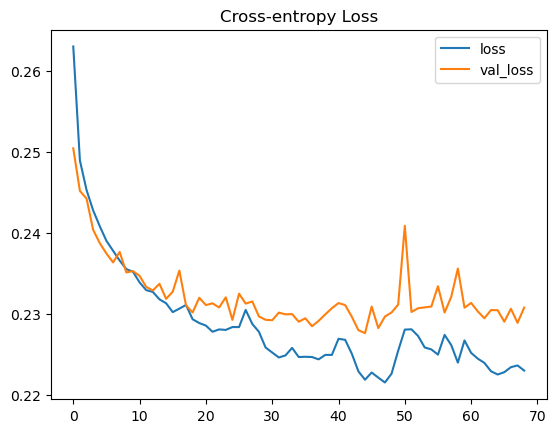

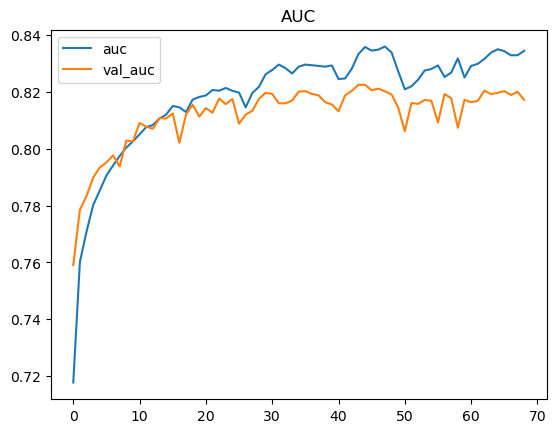

In [44]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_df[['auc', 'val_auc']].plot(title='AUC')
print(f"Best validation AUC: {history_df['val_auc'].max()}")

In [45]:
'''X_all = np.concatenate((X_train, X_dev))
Y_all = np.concatenate((Y_train, Y_dev))
history = model.fit(X_all, Y_all, epochs=25, batch_size=512)'''

'X_all = np.concatenate((X_train, X_dev))\nY_all = np.concatenate((Y_train, Y_dev))\nhistory = model.fit(X_all, Y_all, epochs=25, batch_size=512)'

## 7 - TensorFlow

## 8 - Numpy

## 9 - Make predictions on the test set

In [46]:
del(X_train)
del(X_dev)
del(Y_train)
del(Y_dev)

In [47]:
X_test = pd.read_csv('data/bank_data_test.csv', index_col='ID')
X_test.drop(columns=useless_cols + ['TARGET'], inplace=True)
index_test = X_test.index

In [48]:
X_test_categorical = X_test.select_dtypes(include=["object_"])
X_test.drop(columns=categorical_cols, inplace=True)
X_test_categorical = X_test_categorical.apply(lambda c: c.str.lower())
X_test_categorical['CLNT_TRUST_RELATION'].replace(ru_to_en, inplace=True)

In [49]:
X_test.fillna(medians, inplace=True)

In [50]:
X_test_categorical_encoded = pd.DataFrame()

In [51]:
for col in categorical_cols:
    X_test_categorical_encoded[col] = X_test_categorical[col].astype(pd.CategoricalDtype(categories=categories[col]))
    X_test_categorical_encoded[col] = X_test_categorical_encoded[col].cat.codes

In [52]:
del(X_test_categorical)

In [53]:
X_test = pd.concat([X_test, X_test_categorical_encoded], axis=1)

In [54]:
del(X_test_categorical_encoded)

In [55]:
X_test = scaler.transform(X_test)

Save the final predictions to a csv file.

In [56]:
test_predictions = best_model.predict(X_test)
pd.DataFrame(test_predictions, index=index_test, columns=['TARGET']).to_csv('final_predictions.csv')

2775/2775 [==============================] - 4s 2ms/step


In [57]:
test_predictions.mean()

0.078145415